In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random


from termcolor import colored

from sklearn.model_selection import train_test_split, cross_validate, KFold, learning_curve,validation_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer


from mlxtend.evaluate import bias_variance_decomp

# Model
# --------------------------------------------------------------------
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

In [2]:
def ROC(X_test,y_test):
    y_pred_proba = model.predict_proba(X_test)
    lr_probs = y_pred_proba[:,1]
    ns_probs = [0 for _ in range(len(y_test))]
    ns_auc = metrics.roc_auc_score(y_test, ns_probs)
    lr_auc = metrics.roc_auc_score(y_test, lr_probs)
    ns_fpr, ns_tpr, thresholds  = metrics.roc_curve(y_test,ns_probs)
    lr_fpr, lr_tpr, thresholds = metrics.roc_curve(y_test, lr_probs)
    plt.plot(ns_fpr,ns_tpr,linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='DT')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Treeb: ROC AUC=%.3f' % (lr_auc))

Imprime las metricas de los modelos

In [3]:
def metricas(validacion, prediccion, churm):
    
    print("Exactitud: ", metrics.accuracy_score(validacion, prediccion))
    print("Kappa: ", metrics.cohen_kappa_score(validacion, prediccion))
    
    print(colored('Metricas de los registros mineros', attrs=['bold']))
    
    print("Precisión: ",  metrics.precision_score(validacion, prediccion, labels=[1], average='macro'))
    print("Recall: ",  metrics.recall_score(validacion, prediccion, labels=[1], average='macro'))
    
    VN = churm[0,0]
    FP = churm[0,1]
    specificity = VN/(VN+FP)
    
    print("Especificidad : ", specificity)
    print("F1-score      : ", metrics.f1_score(validacion, prediccion, labels=[1], average='macro'))
    
    
    print(colored('Metricas de los registros no mineros', attrs=['bold']))
    
    print("Precisión: ",  metrics.precision_score(validacion, prediccion, labels=[0], average='macro'))
    print("Recall: ",  metrics.recall_score(validacion, prediccion, labels=[0], average='macro'))
    
    VN = churm[1,1]
    FP = churm[1,0]
    specificity = VN/(VN+FP)
    
    print("Especificidad : ", specificity)
    print("F1-score      : ", metrics.f1_score(validacion, prediccion, labels=[0], average='macro'))

In [4]:
def matriz_confusion(validacion, prediccion, cmap):
    
    churm = metrics.confusion_matrix(validacion, prediccion)
    fig,ax = plt.subplots(nrows = 1, ncols = 1,figsize = (8,6))
    sns.heatmap(churm, annot=True, ax = ax,cmap=cmap,fmt='g',annot_kws={"size": 15});

    #plt.imshow(churm, cmap=plt.cm.Blues,annot=True)
    ax.set_title("decision tree",size=15)

    ax.xaxis.set_ticklabels(['Not_mine','Mine'])
    ax.yaxis.set_ticklabels(['Not_mine','Mine'])
    ax.tick_params(labelsize = 15)
    
    return churm

In [5]:
def curva_validacion(model, X_train,y_train, param,rango):
    train_prec, eval_prec = validation_curve(estimator = model, X = X_train, y=y_train, param_name=param,param_range=rango, cv =5)
    train_mean = np.mean(train_prec, axis = 1)
    train_std = np.mean(train_prec,axis = 1)
    test_mean = np.mean(eval_prec,axis = 1)
    test_std = np.std(eval_prec,axis=1)
    
    #Grafico
    
    plt.plot(rango,train_mean,color='r', marker = 'o',markersize = 5, label = 'Entrenamiento')
    plt.fill_between(rango, train_mean + train_std, 
                 train_mean - train_std, alpha=0.15, color='r')
    plt.plot(rango, test_mean, color='b', linestyle='--', marker='s', markersize=5, label='evaluacion')
    plt.fill_between(rango, test_mean + test_std, 
                 test_mean - test_std, alpha=0.15, color='b')
    plt.grid()
    plt.legend(loc='center right')
    plt.xlabel('Cant de nodos')
    plt.ylabel('Precision')
    plt.show()

# Importar datos Puros

In [6]:
dataA = pd.read_csv('./data_identificada.csv').drop(['Second_Protocol', 'Third_Protocol','Cryptocurrency'], axis = 1)
dataA.head(1)

,Netflows,First_Protocol,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,...,first_dp,second_dp,third_dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type
0,82,TCP,2.9595,103.6315,135.19425,6709.539,184.327,0.0,407,1266,...,443,5355.0,80.0,3.0,5.0,5.75,84.0,160.0,248.0,not_mine


# Preprocesamiento

### Imputación de valores ausentes

In [7]:
punter = pd.concat([dataA['second_sp'],dataA['second_dp'],dataA['third_sp'],dataA['third_dp']],axis=1)
imputer = SimpleImputer(missing_values = np.nan, strategy = "median")
values = imputer.fit_transform(punter)

In [8]:
punter = pd.DataFrame(values, columns = punter.columns)
dataA['second_sp'] = punter['second_sp']
dataA['second_dp'] = punter['second_dp']
dataA['third_sp'] = punter['third_sp']
dataA['third_dp'] = punter['third_dp']

In [9]:
dataCopyA = dataA
dataA.shape

(4733, 28)

In [10]:
print(colored('Como los registros benignos son los mismos para cada conjunto de datos, sacare aleatoriamente el 70% para utilizarlos para el entreno de modelos posteriores, y emular con el 30% datos de testeo', attrs=['bold']))
porcion_no_minera_conjuntoA = dataCopyA[dataCopyA.Type == "not_mine"]
porcion_no_minera_conjuntoA = porcion_no_minera_conjuntoA.sample(n=750)

Como los registros benignos son los mismos para cada conjunto de datos, sacare aleatoriamente el 70% para utilizarlos para el entreno de modelos posteriores, y emular con el 30% datos de testeo


In [11]:
porcion_no_minera_conjuntoA.shape

(750, 28)

In [12]:
dataA.shape

(4733, 28)

In [13]:
dataA = dataA[~dataA.index.isin(porcion_no_minera_conjuntoA.index)]

Balance del conjunto de datos


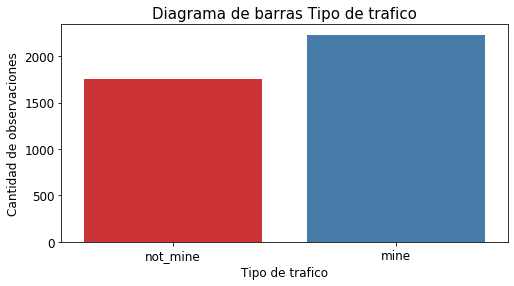

In [14]:
print(colored(f'Balance del conjunto de datos', attrs=['bold']))
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x='Type', data=dataA, palette="Set1")
ax.set_title("Diagrama de barras Tipo de trafico", size=15)
ax.set_xlabel('Tipo de trafico', size = 12)
ax.set_ylabel('Cantidad de observaciones',  size = 12)
ax.tick_params(labelsize = 12)

### OneHotEncoder

In [15]:
data_categoric = dataA[dataA.select_dtypes(include = ['object']).columns.to_list()]
one_hot = OneHotEncoder()
one_hot.fit_transform(data_categoric)

<3983x5 sparse matrix of type '<class 'numpy.float64'>'
	with 7966 stored elements in Compressed Sparse Row format>

In [16]:
data_dummy = pd.get_dummies(data_categoric)
data_dummy.head(2)

,First_Protocol_ICMP,First_Protocol_TCP,First_Protocol_UDP,Type_mine,Type_not_mine
2,0,1,0,0,1
3,0,1,0,1,0


In [17]:
dataA = dataA.drop(['First_Protocol','Type'],axis = 1)

In [18]:
dataA = pd.concat([dataA,data_dummy], axis = 1)
dataA.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'First_Protocol_ICMP', 'First_Protocol_TCP', 'First_Protocol_UDP',
       'Type_mine', 'Type_not_mine'],
      dtype='object')

# Árbol de decisión

In [19]:
best_feature_pure = ['Avg_bps','Avg_bpp' ,'Avg_pps','p3_ip','p3_ib']

In [20]:
y = dataA['Type_mine']
X = dataA[best_feature_pure]

### Holdout

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7)

### Modelo

In [22]:
print(colored('Instancio el modelo de arbol de decisión', attrs=['bold']))
model = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

Instancio el modelo de arbol de decisión


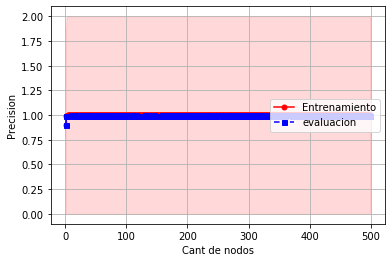

In [23]:
max_deep_list = list(range(1, 500))

curva_validacion(model,X_train,y_train,'max_depth', max_deep_list)

In [24]:
print(colored('Entreno el modelo', attrs=['bold']))
model.fit(X_train,y_train)

Entreno el modelo


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Grafico el modelo
Profundidad del árbol: 5
Número de nodos terminales: 13


[Text(296.4375, 498.3, 'Avg_pps <= 1.5\nsamples = 2788\nvalue = [1193, 1595]\nclass = i'),
 Text(174.375, 407.70000000000005, 'p3_ib <= 702.5\nsamples = 1868\nvalue = [281, 1587]\nclass = i'),
 Text(104.625, 317.1, 'Avg_bps <= 71.5\nsamples = 287\nvalue = [279, 8]\nclass = T'),
 Text(69.75, 226.5, 'p3_ib <= 156.625\nsamples = 13\nvalue = [5, 8]\nclass = i'),
 Text(34.875, 135.89999999999998, 'samples = 5\nvalue = [5, 0]\nclass = T'),
 Text(104.625, 135.89999999999998, 'samples = 8\nvalue = [0, 8]\nclass = i'),
 Text(139.5, 226.5, 'samples = 274\nvalue = [274, 0]\nclass = T'),
 Text(244.125, 317.1, 'Avg_bps <= 1779.5\nsamples = 1581\nvalue = [2, 1579]\nclass = i'),
 Text(209.25, 226.5, 'p3_ip <= 10.625\nsamples = 1580\nvalue = [1, 1579]\nclass = i'),
 Text(174.375, 135.89999999999998, 'p3_ip <= 10.375\nsamples = 152\nvalue = [1, 151]\nclass = i'),
 Text(139.5, 45.299999999999955, 'samples = 151\nvalue = [0, 151]\nclass = i'),
 Text(209.25, 45.299999999999955, 'samples = 1\nvalue = [1, 0

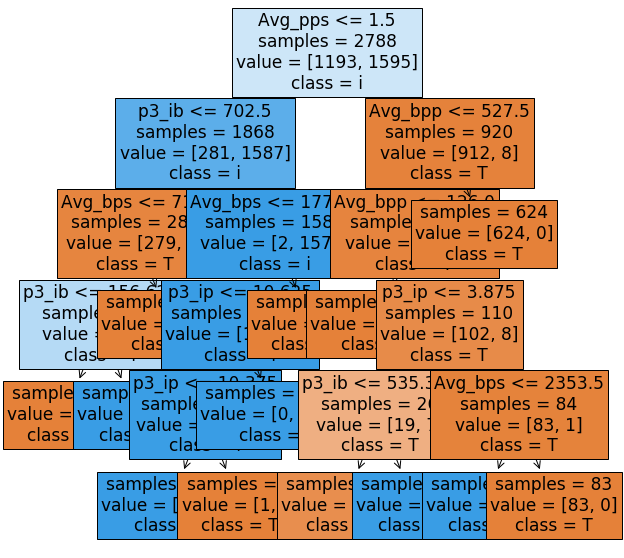

In [25]:
print(colored('Grafico el modelo', attrs=['bold']))
fig, ax = plt.subplots(figsize = (10,10))

print(colored(f'Profundidad del árbol: {model.get_depth()}', attrs=['bold']))
print(colored(f'Número de nodos terminales: {model.get_n_leaves()}', attrs=['bold']))


plot_tree(
    decision_tree = model,
    feature_names = X_train.columns.tolist(),
    class_names   = 'Tipo de trafico minero',
    filled        = True,
    impurity      = False,
    fontsize      = 17,
    ax            = ax
)

In [26]:
print(colored('Realizo la predicción del modelo con la porción de prueba', attrs=['bold']))
y_pred = model.predict(X_test)
y_pred

Realizo la predicción del modelo con la porción de prueba


array([0, 0, 1, ..., 0, 0, 1], dtype=uint8)

In [27]:
len(y_pred[y_pred == 0])

568

In [28]:
len(y_pred[y_pred == 1])

627

In [29]:
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(model, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), loss='0-1_loss')

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 0.007
Average bias: 0.007
Average variance: 0.003


### Métricas y matriz de confusión

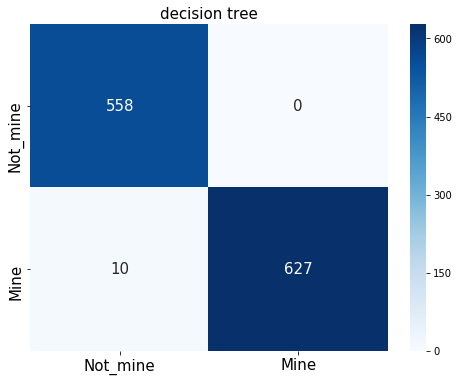

In [30]:
churm = matriz_confusion(y_test, y_pred, plt.cm.Blues)

In [31]:
pd.DataFrame(churm)

,0,1
0,558,0
1,10,627


In [32]:
print("El modelo arbol de dicición se equivocó en %d de los %d registros que componen el dataset de mineria no pura"
      % ((y_test != y_pred).sum(), dataA.shape[0]))

El modelo arbol de dicición se equivocó en 10 de los 3983 registros que componen el dataset de mineria no pura


In [33]:
metricas(y_test, y_pred, churm)

Exactitud:  0.9916317991631799
Kappa:  0.9832087926911177
Metricas de los registros mineros
Precisión:  1.0
Recall:  0.9843014128728415
Especificidad :  1.0
F1-score      :  0.9920886075949367
Metricas de los registros no mineros
Precisión:  0.9823943661971831
Recall:  1.0
Especificidad :  0.9843014128728415
F1-score      :  0.9911190053285969


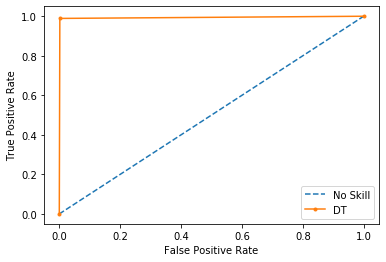

No Skill: ROC AUC=0.500
Treeb: ROC AUC=0.994


In [34]:
ROC(X_test,y_test)

# Experimento 1

In [35]:
print(colored('Importo el conjunto de datos no puros', attrs=['bold']))
dataB = pd.read_csv('./data_no_identificada.csv').drop(['Name','Second_Protocol', 'Third_Protocol'], axis = 1)
dataB.columns

Importo el conjunto de datos no puros


Index(['Netflows', 'First_Protocol', 'p1_d', 'p2_d', 'p3_d', 'duration',
       'max_d', 'min_d', '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes',
       '#sp', '#dp', 'first_sp', 'second_sp', 'third_sp', 'first_dp',
       'second_dp', 'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib',
       'p3_ib', 'Type'],
      dtype='object')

In [36]:
dataB = pd.concat([dataB[dataB.Type == 'mine'],porcion_no_minera_conjuntoA], axis = 0)

### Imputar valores

In [37]:
punter = pd.concat([dataB['second_sp'],dataB['third_sp'],dataB['second_dp'],dataB['third_dp']], axis = 1)
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
values = imputer.fit_transform(punter)

In [38]:
punter = pd.DataFrame(values, columns = punter.columns)
dataB['second_sp'] = punter['second_sp']
dataB['second_dp'] = punter['second_dp']
dataB['third_sp'] = punter['third_sp']
dataB['third_dp'] = punter['third_dp']

### OneHotEncoder

In [39]:
data_categoric = dataB[dataB.select_dtypes(include = ['object']).columns.to_list()]
one_hot = OneHotEncoder()
one_hot.fit_transform(data_categoric)

<37803x6 sparse matrix of type '<class 'numpy.float64'>'
	with 75606 stored elements in Compressed Sparse Row format>

In [40]:
data_dummy = pd.get_dummies(data_categoric).drop('Type_not_mine',axis=1)
data_dummy.head(2)

,First_Protocol_ICMP,First_Protocol_ICMP6,First_Protocol_TCP,First_Protocol_UDP,Type_mine
0,0,0,1,0,1
1,0,0,1,0,1


In [41]:
dataB = pd.concat([dataB,data_dummy], axis = 1).drop(['First_Protocol','Type'],axis=1)
dataB.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'First_Protocol_ICMP', 'First_Protocol_ICMP6', 'First_Protocol_TCP',
       'First_Protocol_UDP', 'Type_mine'],
      dtype='object')

In [42]:
X_train.columns

Index(['Avg_bps', 'Avg_bpp', 'Avg_pps', 'p3_ip', 'p3_ib'], dtype='object')

In [43]:
X = dataB[best_feature_pure]
y = dataB['Type_mine']

### Realizo la predicción

In [44]:
y_pred = model.predict(X)
y_pred

array([0, 0, 1, ..., 0, 0, 0], dtype=uint8)

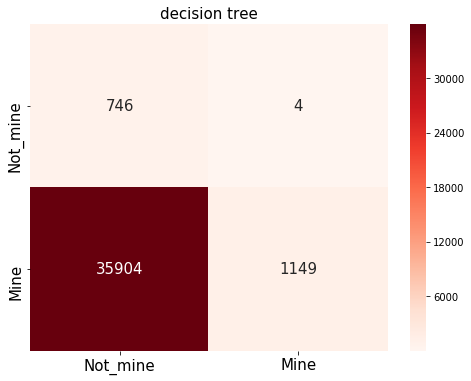

In [45]:
churm = matriz_confusion(y, y_pred, plt.cm.Reds)

In [46]:
pd.DataFrame(churm)

,0,1
0,746,4
1,35904,1149


In [47]:
print("El modelo de en el experimento 1 se equivocó en %d de los %d registros que componen el dataset de mineria no pura"
      % ((y != y_pred).sum(), dataB.shape[0]))

El modelo de en el experimento 1 se equivocó en 35908 de los 37803 registros que componen el dataset de mineria no pura


In [48]:
metricas(y, y_pred, churm)

Exactitud:  0.05012829669602942
Kappa:  0.0010502030676953211
Metricas de los registros mineros
Precisión:  0.9965307892454467
Recall:  0.031009634847380778
Especificidad :  0.9946666666666667
F1-score      :  0.060147620792545674
Metricas de los registros no mineros
Precisión:  0.02035470668485675
Recall:  0.9946666666666667
Especificidad :  0.031009634847380778
F1-score      :  0.03989304812834225


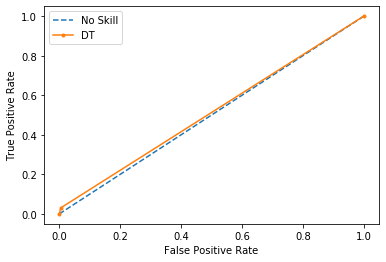

No Skill: ROC AUC=0.500
Treeb: ROC AUC=0.513


In [49]:
ROC(X,y)

# Experimento 2

In [50]:
print(colored('Caracteristicas del conjunto de datos no puro', attrs=['bold']))
best_feature_noPure = ['min_d', 'second_sp','second_dp','Type_mine']
print(best_feature_noPure)

Caracteristicas del conjunto de datos no puro
['min_d', 'second_sp', 'second_dp', 'Type_mine']


In [51]:
print(colored('Combino las caracteristicas y agrego la variable objetivo', attrs=['bold']))
bestFeature = np.concatenate([best_feature_pure,best_feature_noPure])
bestFeature = np.unique(bestFeature)
bestFeature

Combino las caracteristicas y agrego la variable objetivo


array(['Avg_bpp', 'Avg_bps', 'Avg_pps', 'Type_mine', 'min_d', 'p3_ib',
       'p3_ip', 'second_dp', 'second_sp'], dtype='<U9')

In [52]:
print(colored('Aplico una tecnica de submuestreo para equilibrar las clases del conjunto de datos no puros,  con la finalidad de balanciar el conjunto de datos', attrs=['bold']))
porcion_minera_conjuntoB = dataB[dataB.Type_mine == 1]
porcion_minera_conjuntoB = porcion_minera_conjuntoB.sample(n=dataCopyA[dataCopyA.Type == "mine"].shape[0])

Aplico una tecnica de submuestreo para equilibrar las clases del conjunto de datos no puros,  con la finalidad de balanciar el conjunto de datos


In [53]:
print(colored('Unimos los conjuntos de datos y aplicamos aleatoriedad en la posición de los registros', attrs=['bold']))


Unimos los conjuntos de datos y aplicamos aleatoriedad en la posición de los registros


In [54]:
copy_porcion_minera_conjuntoB = porcion_minera_conjuntoB 

In [55]:
data_final = pd.concat([dataA[bestFeature], porcion_minera_conjuntoB[bestFeature], ], axis = 0)
data_final.shape

(6215, 9)

Balance del conjunto de datos


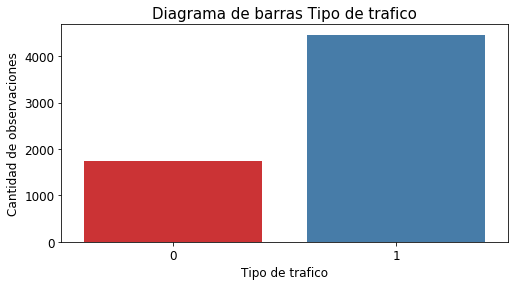

In [56]:
print(colored(f'Balance del conjunto de datos', attrs=['bold']))
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x='Type_mine', data=data_final, palette="Set1")
ax.set_title("Diagrama de barras Tipo de trafico", size=15)
ax.set_xlabel('Tipo de trafico', size = 12)
ax.set_ylabel('Cantidad de observaciones',  size = 12)
ax.tick_params(labelsize = 12)

In [57]:
sobre_muestreo_no_minera = data_final[data_final.Type_mine == 0]
data_final = pd.concat([data_final, sobre_muestreo_no_minera], axis = 0)
data_final.shape

(7966, 9)

Balance del conjunto de datos


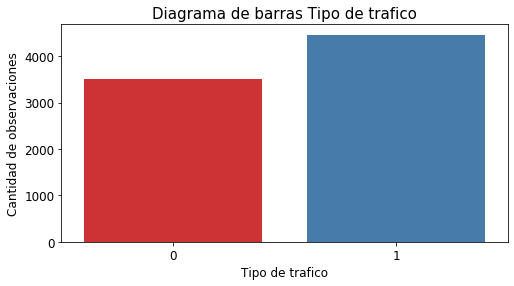

In [58]:

print(colored(f'Balance del conjunto de datos', attrs=['bold']))
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x='Type_mine', data=data_final, palette="Set1")
ax.set_title("Diagrama de barras Tipo de trafico", size=15)
ax.set_xlabel('Tipo de trafico', size = 12)
ax.set_ylabel('Cantidad de observaciones',  size = 12)
ax.tick_params(labelsize = 12)

In [59]:
print(colored('Aleatoriedad', attrs=['bold']))
data_final = data_final.reset_index()
indices = list(data_final.index)
random.shuffle(indices)
data_final = data_final.reindex(indices)
data_final.head()

Aleatoriedad


,index,Avg_bpp,Avg_bps,Avg_pps,Type_mine,min_d,p3_ib,p3_ip,second_dp,second_sp
63,78,135,1320,1,1,39.761,18006.00,193.5,58780.0,58780.0
627,741,864,126914,18,0,0.000,664.00,9.5,80.0,80.0
883,1055,111,3838,4,0,0.000,341.25,8.0,80.0,80.0
5231,20265,105,89,0,1,0.000,40.00,1.0,1281.0,3333.0
1549,1839,124,55,0,1,540.749,2484.25,15.0,14444.0,14444.0


In [60]:
data_final.drop(['index'],axis =1, inplace=True)

In [61]:
data_final['Type_mine'] = data_final['Type_mine'].astype('int')

In [62]:
data_final.shape

(7966, 9)

### Modelo

In [63]:
X = data_final.drop('Type_mine', axis = 1)
y = data_final['Type_mine']

In [64]:
model = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

In [65]:
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
scores = cross_validate(model, X, y, scoring=scoring, cv=10, return_train_score=False)

for key in scores:
    score = scores[key]
    print("%s: %0.2f (+/- %0.2f)" % (key, score.mean(), score.std() * 2))


fit_time: 0.06 (+/- 0.04)
score_time: 0.02 (+/- 0.01)
test_accuracy: 0.99 (+/- 0.01)
test_precision_weighted: 0.99 (+/- 0.01)
test_recall_weighted: 0.99 (+/- 0.01)
test_f1_weighted: 0.99 (+/- 0.01)


### Cross Validation-K_fold

In [66]:
K_fold = KFold(n_splits = 10)

In [67]:
resultados_train = []
resultados_test = []
predicciones = []
scores = []
modelos = []


for result in K_fold.split(X):
    resultados_train.append(result[0])
    resultados_test.append(result[1])
    X_train = X.iloc[result[0]]
    X_test =  X.iloc[result[1]]
    y_train =  y.iloc[result[0]]
    y_test =  y.iloc[result[1]]
    model = model.fit(X_train,y_train)
    modelos.append(model)
    predic = model.predict(X_test)
    predicciones.append(predic)
    scores.append(model.score(X_test, y_test))

In [68]:
scores

[0.9824341279799247,
 0.9786700125470514,
 0.9887076537013801,
 0.9849435382685069,
 0.9887076537013801,
 0.986198243412798,
 0.9899497487437185,
 0.9824120603015075,
 0.9886934673366834,
 0.9899497487437185]

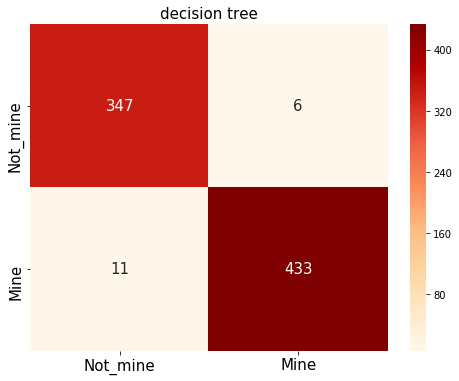

In [69]:
churm = matriz_confusion(y.iloc[resultados_test[1]], predicciones[1], plt.cm.OrRd)

In [70]:
pd.DataFrame(churm)

,0,1
0,347,6
1,11,433


In [71]:
metricas(y.iloc[resultados_test[1]], predicciones[1], churm)

Exactitud:  0.9786700125470514
Kappa:  0.9568391846304302
Metricas de los registros mineros
Precisión:  0.9863325740318907
Recall:  0.9752252252252253
Especificidad :  0.9830028328611898
F1-score      :  0.9807474518686297
Metricas de los registros no mineros
Precisión:  0.9692737430167597
Recall:  0.9830028328611898
Especificidad :  0.9752252252252253
F1-score      :  0.9760900140646976


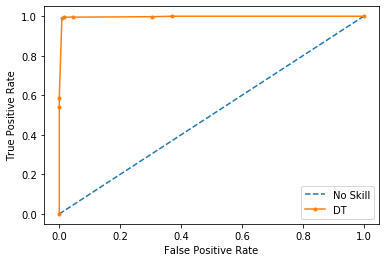

No Skill: ROC AUC=0.500
Treeb: ROC AUC=0.997


In [72]:
ROC(X.iloc[resultados_test[1]],y.iloc[resultados_test[1]])

### Prueba final

In [73]:
porcion_no_minera_conjuntoA.columns

Index(['Netflows', 'First_Protocol', 'p1_d', 'p2_d', 'p3_d', 'duration',
       'max_d', 'min_d', '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes',
       '#sp', '#dp', 'first_sp', 'second_sp', 'third_sp', 'first_dp',
       'second_dp', 'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib',
       'p3_ib', 'Type'],
      dtype='object')

In [74]:
copy_porcion_minera_conjuntoB.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'First_Protocol_ICMP', 'First_Protocol_ICMP6', 'First_Protocol_TCP',
       'First_Protocol_UDP', 'Type_mine'],
      dtype='object')

In [75]:
data_categoric = porcion_no_minera_conjuntoA[porcion_no_minera_conjuntoA.select_dtypes(include = ['object']).columns.to_list()]
one_hot = OneHotEncoder()
one_hot.fit_transform(data_categoric)
data_dummy = pd.get_dummies(data_categoric)
data_dummy.head(2)

,First_Protocol_ICMP6,First_Protocol_TCP,First_Protocol_UDP,Type_not_mine
2006,0,1,0,1
1394,0,1,0,1


In [76]:
data_dummy = data_dummy.rename(columns = {'Type_not_mine':'Type_mine'})
data_dummy['Type_mine'] = data_dummy['Type_mine'].replace({1:0})

In [77]:
porcion_no_minera_conjuntoA = pd.concat([porcion_no_minera_conjuntoA,data_dummy], axis = 1).drop(['First_Protocol'], axis = 1)

In [78]:
dataB = dataB[~dataB.index.isin(porcion_minera_conjuntoB.index)]

In [79]:
dataB.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'First_Protocol_ICMP', 'First_Protocol_ICMP6', 'First_Protocol_TCP',
       'First_Protocol_UDP', 'Type_mine'],
      dtype='object')

In [80]:
porcion_no_minera_conjuntoA.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'Type', 'First_Protocol_ICMP6', 'First_Protocol_TCP',
       'First_Protocol_UDP', 'Type_mine'],
      dtype='object')

In [81]:
prueba_final = pd.concat([porcion_no_minera_conjuntoA[bestFeature],dataB[bestFeature]], axis = 0).replace({np.nan:0})

In [82]:
X_p = prueba_final[bestFeature].drop('Type_mine',axis = 1)
y_p = prueba_final['Type_mine']

In [83]:
y_pred_proba = modelos[1].predict(X_p)

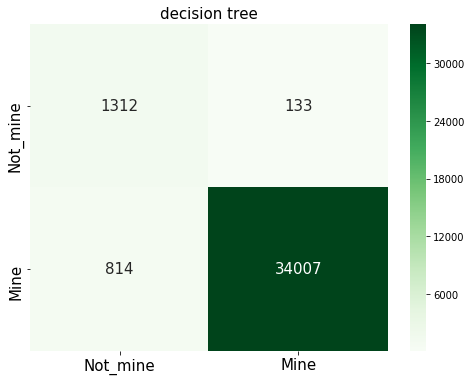

In [84]:
churm = matriz_confusion(y_p, y_pred_proba, plt.cm.Greens)

In [85]:
pd.DataFrame(churm)

,0,1
0,1312,133
1,814,34007


In [86]:
metricas(y_p, y_pred_proba, churm)

Exactitud:  0.9738873876358022
Kappa:  0.7216000655503043
Metricas de los registros mineros
Precisión:  0.9961042765084944
Recall:  0.9766233020303839
Especificidad :  0.9079584775086506
F1-score      :  0.9862676005278346
Metricas de los registros no mineros
Precisión:  0.6171213546566322
Recall:  0.9079584775086506
Especificidad :  0.9766233020303839
F1-score      :  0.7348081769812378


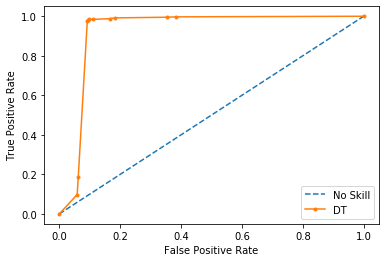

No Skill: ROC AUC=0.500
Treeb: ROC AUC=0.925


In [87]:
ROC(X_p,y_p)

In [88]:
sa

NameError: name 'sa' is not defined

In [ ]:
max_deep_list = list(range(1, 500))

curva_validacion(modelos[1], X_p,y_p,'max_depth', max_deep_list)